## Imports:

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

### Parameters:

In [145]:
# ---- constants ----
# all in electronovolts
h = 4.135667696e-15
h_bar = 6.582119569e-16 #eV*s
m_0 = 5.686e-12 #eV*s/A^2
J_to_eV = 1
alpha_f = 1/137.036

# # all in Si
# h = 6.626e-34
# h_bar = 1.054571e-34
# m_0 = 9.109383e-31

eV_to_J = 1.602176e-19
J_to_eV = 1/eV_to_J
h_bar2_2m = 3.81e-20 #ev*Angstr.^2

# ---- material parameters ----
# GaAs
# Define the material parameters
a_lc = 5.65325e-10
E_p = 25.6#*eV_to_J
E_g = 1.519
#P_cv = h_bar*np.sqrt(E_p/(2*m_0)) # zmienić na formułę z h_bar2_2m
P_cv = np.sqrt(E_p*h_bar2_2m)
exper_alpha_upscaling = 1.45

F = -1.94
delta_so = 0.341

# Define the spin-orbit coupling constants
gamma_1 = 6.98
gamma_2 = 2.06
gamma_3 = 2.93

# optical parameters
epsilon_r = 13.33 # CHANGE !!! always read
n_r = np.sqrt(epsilon_r)

### Abs coeff:

In [146]:
def calc_absorption_coeff(hw):
    """k needs to be in angstrems

    Args:
        k (_type_): _description_

    Returns:
        _type_: _description_
    """
    def norm_sec(x, del_l=0.01):
        y = 1/(np.pi*del_l*np.cosh(x/del_l))

        return y
    
    def integrand(kx, ky, kz, hw):
        # Define the 8x8 Hamiltonian matrix
        H = np.zeros((4,4), dtype=np.complex128)
        
        # with conversion of values from p. 189 
        # file:///D:/Nauka/in%C5%BCynierka/bands-and-photons-in-iii-
        # v-semiconductor-quantum-structures-0198767277-9780198767275_compress.pdf
        
        # Fill in the off-diagonal elements of the Hamiltonian
        inter = (h_bar/m_0*P_cv*1e1)**2
        inter += (h_bar/m_0*P_cv*1e1)**2
        inter += (h_bar/m_0*P_cv*1e1)**2
        
        E_ck = E_g/2+np.sqrt(E_g**2/4+h_bar2_2m*2/3*E_p*np.dot([kx, ky, kz],[kx, ky, kz]))
        E_vk = 0
        inter = inter*hw/(E_ck-E_vk)**2*norm_sec(E_ck-E_vk-hw)
        
        return inter

    k_top = 0.2*2*np.pi/a_lc#/1e10
    #I, err = integrate.tplquad(integrand, 0., k_top, 0., k_top, 0., k_top, args=([hw]))
    
    n_bins = 40
    dk = k_top/n_bins

    k_bins = np.linspace(0, k_top, n_bins+1)
    k_vals = (k_bins[:-1]+k_bins[1:])/2
    I = 0.
    for x_i in range(n_bins):
        for y_i in range(n_bins):
            for z_i in range(n_bins):
                I+=integrand(k_vals[x_i],
                          k_vals[y_i],
                          k_vals[z_i],
                          hw)
    I = I*dk**3
    
    alpha = alpha_f/(2*np.pi*n_r)*I
    
    return alpha


points = 50
alphas = np.zeros((points))
hw_range = np.linspace(1.4,
                       2.0,
                       points)
for i, hw in enumerate(hw_range):
    alphas[i] = calc_absorption_coeff(hw)


alphas = alphas*10000

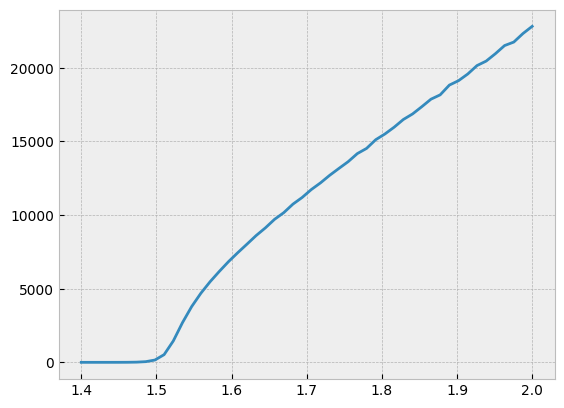

In [147]:
with plt.style.context('bmh'):
    plt.plot(hw_range, alphas)
    plt.show()

## Abs coeff from 8kp band diagrams (0_.4pi range):

In [157]:
# calculation parameters:
k_top = 0.2
points = 50

#### Load band diagrams:

In [158]:
bands = np.load(f'./results/GaAs_300k_8kp_no-strain_{points}points_top{k_top}.npy')
str_bands = np.load(f'./results/GaAs_300k_8kp_strain-0.02_{points}points_top{k_top}.npy')

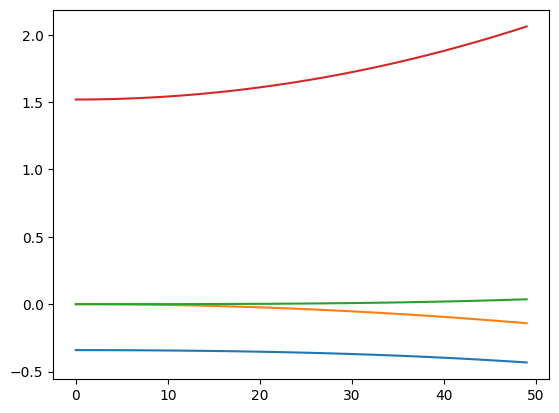

In [159]:
for i in range(4):
    plt.plot(bands[i,0,0,:])
plt.show()

In [166]:
E_bands = bands[:,0,0,0]
E_g = -E_bands[:3]+E_bands[3]

E_str_bands = str_bands[:,0,0,0]
E_g_str = -E_str_bands[:3]+E_str_bands[3]

E_g, E_g_str

(array([1.86 , 1.519, 1.519]), array([1.98796127, 1.61854242, 1.48493857]))

In [167]:
# optical parameters:
#p.631, file:///D:/Nauka/in%C5%BCynierka/bands-and-photons-in-iii-v-semiconductor-quantum-structures-0198767277-9780198767275_compress.pdf
epsilon_r = np.array([14.339,13.33,13.33]) # CHANGE !!! always read from above link
n_r = np.sqrt(epsilon_r)

epsilon_r_str = np.array([14.8,13.57,13.27]) # CHANGE !!! always read from above link
n_r_str = np.sqrt(epsilon_r_str)
n_r, n_r_str

(array([3.78668721, 3.65102725, 3.65102725]),
 array([3.84707681, 3.68374809, 3.64280112]))

#### Calc abs. coeff.:

In [168]:
def calc_absorption_coeff(bands, hw, n_r, k_top=0.2, points=50, del_l=0.005):
    """k needs to be in angstrems

    Args:
        k (_type_): _description_

    Returns:
        _type_: _description_
    """
    def norm_sec(x, del_l=0.005):
        y = 1/(np.pi*del_l*np.cosh(x/del_l))

        return y
    
    def integrand(kx, ky, kz, hw, E_ck, E_vk):
        # Define the 8x8 Hamiltonian matrix
        H = np.zeros((4,4), dtype=np.complex128)
        
        # with conversion of values from p. 189 
        # file:///D:/Nauka/in%C5%BCynierka/bands-and-photons-in-iii-
        # v-semiconductor-quantum-structures-0198767277-9780198767275_compress.pdf
        
        # Fill in the off-diagonal elements of the Hamiltonian
        inter = (h_bar/m_0*P_cv)**2
        inter += (h_bar/m_0*P_cv)**2
        inter += (h_bar/m_0*P_cv)**2
        
        inter = inter*hw/(E_ck-E_vk)**2*norm_sec(E_ck-E_vk-hw, del_l=del_l)
        
        return inter

    k_lim = k_top*2*np.pi/a_lc
    #I, err = integrate.tplquad(integrand, 0., k_lim, 0., k_lim, 0., k_lim, args=([hw]))
    
    n_bins = points
    dk = k_lim/n_bins

    k_bins = np.linspace(0, k_lim, n_bins)
    k_vals = k_bins
    I = np.array([0,0,0], dtype=np.float64)
    valence_indices = [0,1,2]
    for v_i in valence_indices:
        for x_i in range(n_bins):
            #print(f'Valence band [{v_i+1}/{len(valence_indices)}], [{x_i+1}/{n_bins}]', end='\r')
            for y_i in range(n_bins):
                for z_i in range(n_bins):
                    I[v_i]+=integrand(k_vals[x_i],
                            k_vals[y_i],
                            k_vals[z_i],
                            hw,
                            bands[3,x_i,y_i,z_i],
                            bands[v_i,x_i,y_i,z_i]
                            )
    I = I*dk**3
    
    alpha = np.array([0,0,0], dtype=np.float64)
    for band_i in range(3):
        alpha[band_i] = np.array(alpha_f/(2*np.pi*n_r[band_i])*I[band_i])
    
    return alpha

In [171]:
hw_points = 50
valence_bands = 3
alphas = np.zeros((hw_points,valence_bands))
hw_range = np.linspace(1.4,
                       2.0,
                       hw_points)
for i, hw in enumerate(hw_range):
    print(f'[{i+1}/{hw_points}]', end='\r')
    alphas[i] = calc_absorption_coeff(bands, hw, n_r, k_top, points)
    
alphas = alphas*exper_alpha_upscaling*10000*12

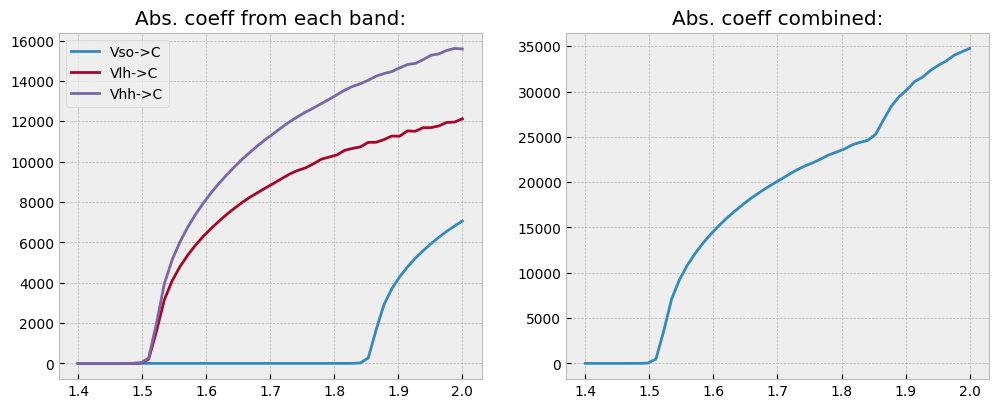

In [173]:
with plt.style.context('bmh'):
    fig, axs = plt.subplots(1,2, figsize=(12,4.5))
    labels = ['Vso->C','Vlh->C','Vhh->C',]
    for i in range(3):
        axs[0].plot(hw_range, alphas[:,i], label=labels[i])
    axs[0].legend()
    axs[1].plot(hw_range, alphas.sum(axis=1))
    
    axs[0].set_title('Abs. coeff from each band:')
    axs[1].set_title('Abs. coeff combined:')
    plt.show()

In [174]:
hw_points = 50
valence_bands = 3
str_alphas = np.zeros((hw_points,valence_bands))
hw_range = np.linspace(1.4,
                       2.0,
                       hw_points)
for i, hw in enumerate(hw_range):
    print(f'[{i+1}/{hw_points}]', end='\r')
    str_alphas[i] = calc_absorption_coeff(str_bands, hw, n_r_str, k_top, points)
    
str_alphas = str_alphas*exper_alpha_upscaling*10000*12

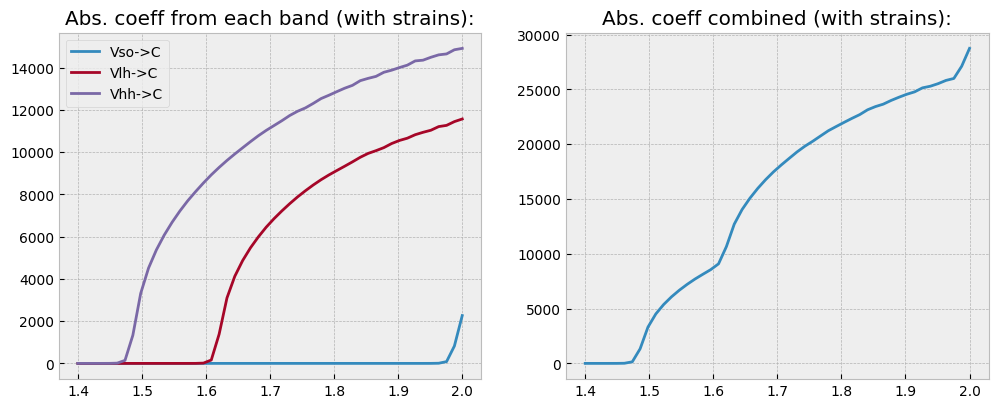

In [175]:
with plt.style.context('bmh'):
    fig, axs = plt.subplots(1,2, figsize=(12,4.5))
    labels = ['Vso->C','Vlh->C','Vhh->C',]
    for i in range(3):
        axs[0].plot(hw_range, str_alphas[:,i], label=labels[i])
    axs[0].legend()
    axs[1].plot(hw_range, str_alphas.sum(axis=1))
    
    axs[0].set_title('Abs. coeff from each band (with strains):')
    axs[1].set_title('Abs. coeff combined (with strains):')
    plt.show()

## Abs coeff from 8kp band diagrams (pi range):

In [176]:
# calculation parameters:
k_top = 0.5
points = 100

#### Load band diagrams:

In [181]:
bands = np.load(f'./results/GaAs_300k_8kp_no-strain_{points}points_top{k_top}.npy')
str_bands = np.load(f'./results/GaAs_300k_8kp_strain-0.02_{points}points_top{k_top}.npy')

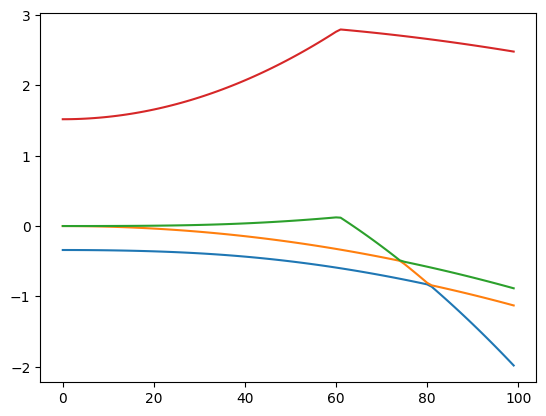

In [182]:
for i in range(4):
    plt.plot(bands[i,0,0,:])
plt.show()

In [183]:
E_bands = bands[:,0,0,0]
E_g = -E_bands[:3]+E_bands[3]

E_str_bands = str_bands[:,0,0,0]
E_g_str = -E_str_bands[:3]+E_str_bands[3]

E_g, E_g_str

(array([1.86 , 1.519, 1.519]), array([1.98796127, 1.61854242, 1.48493857]))

In [184]:
# optical parameters:
#p.631, file:///D:/Nauka/in%C5%BCynierka/bands-and-photons-in-iii-v-semiconductor-quantum-structures-0198767277-9780198767275_compress.pdf
epsilon_r = np.array([14.339,13.33,13.33]) # CHANGE !!! always read from above link
n_r = np.sqrt(epsilon_r)

epsilon_r_str = np.array([14.8,13.57,13.27]) # CHANGE !!! always read from above link
n_r_str = np.sqrt(epsilon_r_str)

#### Calc abs. coeff.:

In [125]:
hw_points = 50
valence_bands = 3
alphas = np.zeros((hw_points,valence_bands))
hw_range = np.linspace(1.4,
                       2.0,
                       hw_points)
for i, hw in enumerate(hw_range):
    print(f'[{i+1}/{hw_points}]', end='\r')
    alphas[i] = calc_absorption_coeff(bands, hw, n_r, k_top, points, del_l=0.02)
    
alphas = alphas*exper_alpha_upscaling*10000*12

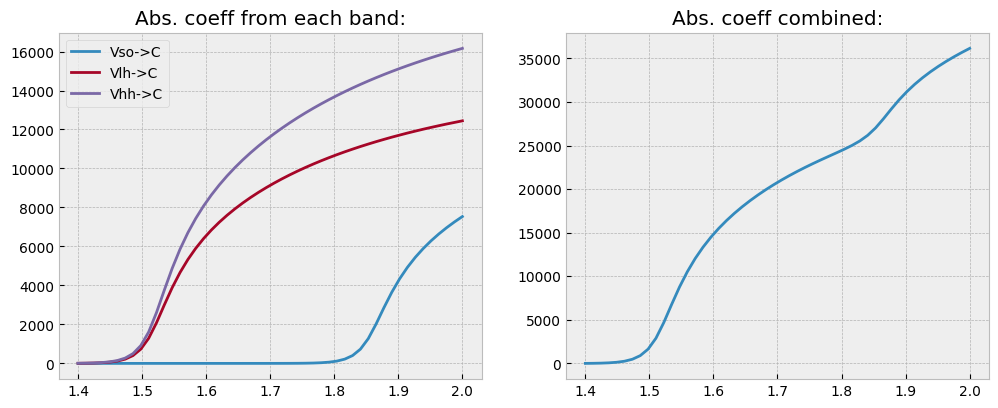

In [126]:
with plt.style.context('bmh'):
    fig, axs = plt.subplots(1,2, figsize=(12,4.5))
    labels = ['Vso->C','Vlh->C','Vhh->C',]
    for i in range(3):
        axs[0].plot(hw_range, alphas[:,i], label=labels[i])
    axs[0].legend()
    axs[1].plot(hw_range, alphas.sum(axis=1))
    
    axs[0].set_title('Abs. coeff from each band:')
    axs[1].set_title('Abs. coeff combined:')
    plt.show()

In [127]:
hw_points = 50
valence_bands = 3
str_alphas = np.zeros((hw_points,valence_bands))
hw_range = np.linspace(1.4,
                       2.0,
                       hw_points)
for i, hw in enumerate(hw_range):
    print(f'[{i+1}/{hw_points}]', end='\r')
    str_alphas[i] = calc_absorption_coeff(str_bands, hw, n_r_str, k_top, points, del_l=0.02)
    
str_alphas = str_alphas*exper_alpha_upscaling*10000*12

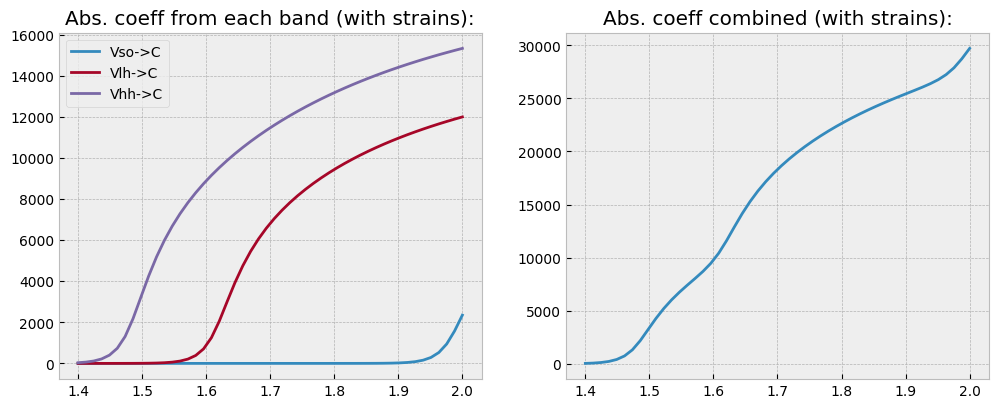

In [128]:
with plt.style.context('bmh'):
    fig, axs = plt.subplots(1,2, figsize=(12,4.5))
    labels = ['Vso->C','Vlh->C','Vhh->C',]
    for i in range(3):
        axs[0].plot(hw_range, str_alphas[:,i], label=labels[i])
    axs[0].legend()
    axs[1].plot(hw_range, str_alphas.sum(axis=1))
    
    axs[0].set_title('Abs. coeff from each band (with strains):')
    axs[1].set_title('Abs. coeff combined (with strains):')
    plt.show()